Non Linear Fitting - third version

In this version 
* I turn back to simulate $S_n$ each step (instead of using binomial).

* Implemented a bar of progress.

* The number of simulations decreases by halt with k (e.g. 128 simulations of size $2^8$, 64 simulations of size $2^9$, 32 simulations of size $2^{10}, ... ).

* Implemented Roberto's estimator $f(k) = 2 \zeta(k+1) - \zeta(k) $.

* Correct the confidence interval for quantiles (but still wrong for Roberto's estimator)

* (to do) Change the size $n=2^k$, to something like $n = \gamma^k$ (for $1<\gamma<2$) in order to get more points and see if the graphic looks like more of a shape curve $a + b*k + c*\exp(d*k)$

Conclusions
* The number of simulations decreases exponecially and the time to take one simulation for each $k$ increases exponencially, the both exponencials have basis $2$, therefore the time to complete each $k$ is almost the same.

* Using Roberto's estimator we can see a beautiful graphic that looks like $a + bk + c*\exp(-d*k)$, except for some giggles for low values of $k$.

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import numpy as np
from scipy.stats import norm
import statistics 
import sys # I used this for creating a progress bar for the simulation
import time
from scipy.optimize import least_squares # for nonlinear regression usinf min squares
# seed the pseudorandom number generator
from random import seed
from random import random
seed(2005) # seed random number generator
start_time = time.time()

#creating a progress bar for simulation
def progress_bar(iteration, total, prefix='', suffix='', length=30, fill='█'):
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    sys.stdout.write(f'\r{prefix} |{bar}| k = {iteration+start} of {point2-1} ')
    sys.stdout.flush()


#defining the sizes of k, 
point1 = 10
point2 = 17
start = 5
numbsimul = [0]*(point2-start+1)
numbsimul[0] = 2**24
gamma = 2 # is the rate of numbsimul of k-1 and numbsimul of k
Size = np.linspace(start, point2-1, point2-start)

A = []

# simulations of random walks
progress_bar(0, point2-start-1, prefix='Progress:', suffix = point2, length=50)
for k in range(0,point2-start):
    n=pow(2,k+start)
    v = [0]*numbsimul[0]

    for j in range(1,numbsimul[k]):
        x = 0
    
        for i in range(1,n):
            
            if random()> 0.5:
                x=x+1
            else:
                x=x-1
            
        v[j-1] = x
    A.append(v)
    numbsimul[k+1] = int(numbsimul[k]/2)
    
    progress_bar(k, point2-start-1, prefix='Progress:', suffix = point2, length=50)
    

# taking absolute value of S_n, sorting the samples, calculate mean and median.
def treat_this_data(A):
    absA = [np.abs(A[i]) for i in range(point2-start)]
    meanA = [0]*(point2 - start)
    median = [0]*(point2 - start)
    sortedAbs = []
    for i in range(point2 - start):
        v = absA[i][slice(numbsimul[i]-1)]
        meanA[i] = np.mean(v)
        sortedAbs.append(np.sort(v))
        median[i] = sortedAbs[i][int(0.5*numbsimul[i])]
    
    return (absA, meanA, median, sortedAbs)

print("\n--- simulation finished in %s seconds ---" % (time.time() - start_time))




Progress: |██████████████████████████████████████████████████| k = 16 of 16 
--- simulation finished in 1176.9213161468506 seconds ---


Roberto's Estimator

For the Roberto's estimator we have an heuristic, we are supposing that $\mathbb{E}(\log|S_n|) \sim \zeta(k) : = a + bk + c 2^{-k}  $, consider the following estimator

$$\begin{align*}
 f(k): =& 2\zeta(k) - \zeta(k-1) \\
 =& 2a + 2bk + 2c2^{-k} - a - b(k-1) -c2^{k-1} \\
 =& a +b(k+1)
 \end{align*}
$$
This estimator cancels the *first bias term* $c 2^{-k}$, so we expect that the graphic is closer to a line.

In [7]:
# takes f(k) = 2 * S_{k} - S_{k-1}
def f(list):
    A = np.zeros(len(list)-1)
    for k in range(1,len(list)):
        A[k-1] = 2*list[k] - list[k-1]
    
    return A

The next part calculates the confidence interval given Wilson's method.

Suppose that we have $n$ samples (of a random walk) $X_1 \leq X_2 \leq \ldots \leq X_{n}$, sorted increasing.
Therefore, the median(estimator) is $m=X_{\frac{n}{2}}$, in geral the q-quantile(estimator) is $m_q=X_{q\cdot n}$.

By definition of median $\mathbb{P}(X_i \leq m) = \mathbb{P}(X_i \geq m) = \frac{1}{2}$, 
In general, $\mathbb{P}(X_i \leq m_q) = q$ and $\mathbb{P}(X_i \geq m_q) = 1-q$.

So the index $i_m$ of $X_i$ that best represents the median has a binomial distribution $Bin(n,\frac{1}{2})$, in general, the index $i_q$ that best represents the q-quantile has a binomial distribution $Bin(n,q)$.

We can use normal aproximation of binomial in order to construct a confidence interval. 
Fix $\alpha>0$ a confidence level and take $Z_\alpha$ such that $\mathbb{P}(-Z_{\alpha} \leq N(0,1) \leq Z_{\alpha})\geq 1-\alpha$,
$$Z_m=\frac{i_m - \frac{1}{2}n}{\frac{1}{2}\sqrt{n}}\sim N(0,1)$$

$$Z_q=\frac{i_q - q\cdot n}{\sqrt{q (1-q) n}}\sim N(0,1)$$

For the median the confidence interval will be given by the formula

$$index = \frac{1}{2}n \pm \frac{1}{2}\sqrt{n} \cdot Z_\alpha$$

In general for the q-quantile

$$index = q\cdot n  \pm \sqrt{q(1-q)n}\cdot Z_\alpha$$

Obs: In previus simulations I used the formula for median interval of confidence for q-quantiles interval of confidence, which gives a strange error bar.

In [8]:
# calculating the interval of confidence
alpha = 0.001 # confidence level

def confidence_level(q,logq, size, roberto, sortedAbs):
    lowerboundindex = [0]*(size)
    upperboundindex = [0]*(size)
    lowerboundheight = [0]*(size)
    upperboundheight = [0]*(size)
    loglower = [0]*(size)
    logupper = [0]*(size)
    for i in range(size):
        lowerboundindex[i] = math.floor(q*numbsimul[i] - math.sqrt(q*(1-q)*numbsimul[i])*norm.isf(alpha)) 
        upperboundindex[i] = math.ceil(q*numbsimul[i] + math.sqrt(q*(1-q)*numbsimul[i])*norm.isf(alpha)) 

        lowerboundheight[i] = sortedAbs[i][lowerboundindex[i]]
        upperboundheight[i] = sortedAbs[i][upperboundindex[i]]
        loglower[i] = np.log(lowerboundheight[i])/np.log(2)
        logupper[i] = np.log(upperboundheight[i])/np.log(2)

    #confidence interval for Roberto's estimator
    if (roberto == 'true'):
        logupper = f(logupper)
        loglower = f(loglower)
        logq = f(logq)

    errorbar = [np.abs(loglower-logq), np.abs(logupper-logq)]
    
    return errorbar

Here is done all regressions

In [10]:
# fit_func (k) = a * k + b + c * exp ( -d * k )
def fit_func(param,k):
    return param[0]*k + param[1] + param[2]*np.exp(-param[3]*k )
# cost function for minimum squares
def cost(param, k , data):
    return fit_func(param,k) - data

param = np.array([1,1,1,1])

# this function draws a graphic of non-linear regresion and linear regression of the samples, 
# parameter q is the desired quantile and parameter "roberto" asks if you want to use roberto's estimator or not
def regression(q, Size, A, roberto):
    B = treat_this_data(A)
    absA = B[0]
    meanA = B[1]
    median = B[2]
    sortedAbs = B[3]
    quantile = [0]*(point2-start)
    for i in range(point2 - start):
        quantile[i] = sortedAbs[i][int(q*numbsimul[i])]

    logquantile = np.log(quantile)/np.log(2)
    logmean = np.log(meanA)/np.log(2)
    logmedian = np.log(median)/np.log(2)
    errorbar = confidence_level(q,logquantile, len(Size),roberto, sortedAbs)

    # linear regression 
    if (roberto == 'true'):
        logmean = f(logmean)
        logmedian = f(logmedian)
        logquantile = f(logquantile)
        Size = np.linspace(start, point2-2, point2-start-1)

    if (len(Size) > 2):
        # non linear regression
        func = least_squares(cost, param, args=(Size,logquantile))
        pmean = least_squares(cost, param, args=(Size,logmean))
        pmedian = least_squares(cost, param, args=(Size,logmedian))
    
    linear = np.polyfit(Size, logquantile, 1)
    linearmean = np.polyfit(Size, logmean, 1)
    linearmedian = np.polyfit(Size, logmedian, 1)
    if (roberto == 'true'):
        print("------------------------------------------------------------------------------------")
        print("---------------------------- Roberto's Estimator -----------------------------------")
        print("------------------------------------------------------------------------------------")

    
    
    if (len(Size)>2):
        print("-----------------------Non-linear approximation-------------------------------------")
        print("------------------------------------------------------------------------------------")
        print("----------- quantile %s gives |coef. diff. - 0.5| = %s----------" % (q,abs(0.5-func.x[0])))
        print("------------------------------------------------------------------------------------")
        print("---------- f(k) = {:.3} + {:.3}*k + {:.3} * exp( -{:.3}*k) ---------------------".format(func.x[1], func.x[0], func.x[2], func.x[3]))
        
        # Print non-linear graphics
        
        plt.errorbar(Size,logquantile,yerr=errorbar,linestyle = 'None', label = 'quantile {:.2}'.format(q),capsize=4, marker = 'o')
        plt.plot(Size, fit_func(pmedian.x,Size), label='median gives coef. of diff. {:.5}'.format(pmedian.x[0]))
        plt.plot(Size, fit_func(func.x,Size), label='quantile {:.2} gives coef. of diff. {:.5}'.format(q,func.x[0]))
        plt.plot(Size, fit_func(pmean.x,Size), label=' mean gives coef. of diff. {:.5}'.format(pmean.x[0]))

        plt.legend(fontsize=12)
        plt.show()
        
        if (roberto == 'true'):
            print("------------------------------------------------------------------------------------")
            print("---------------------------- Roberto's Estimator -----------------------------------")
            print("------------------------------------------------------------------------------------")

    print("---------------------------Linear approximation-------------------------------------")
    print("------------------------------------------------------------------------------------")
    print("---------- quantile %s gives |coeff. diff. - 0.5| = %s ----------" % (q,abs(0.5 - linear[0])))
    

    # Printing linear graphics
    plt.errorbar(Size,logquantile,yerr=errorbar, linestyle = 'None',label = 'quantile {:.2}'.format(q),capsize=4, marker = 'o')
    plt.plot(Size, linear[1]+linear[0]*Size, label='y={:.5}x+{:.2} , quantile {:.2}'.format(linear[0],linear[1], q))
    plt.plot(Size, linearmedian[1]+linearmedian[0]*Size, label='y={:.5}x+{:.2}, median'.format(linearmedian[0],linearmedian[1]))
    plt.plot(Size, linearmean[1]+linearmean[0]*Size, label='y={:.5}x+{:.2}, mean'.format(linearmean[0],linearmean[1]))

    plt.legend(fontsize=12)
    plt.show()  




-----------------------Non-linear approximation-------------------------------------
------------------------------------------------------------------------------------
----------- quantile 0.5 gives |coef. diff. - 0.5| = 0.0190900159539219----------
------------------------------------------------------------------------------------
---------- f(k) = -0.82 + 0.519*k + -0.0726 * exp( -5.62*k) ---------------------


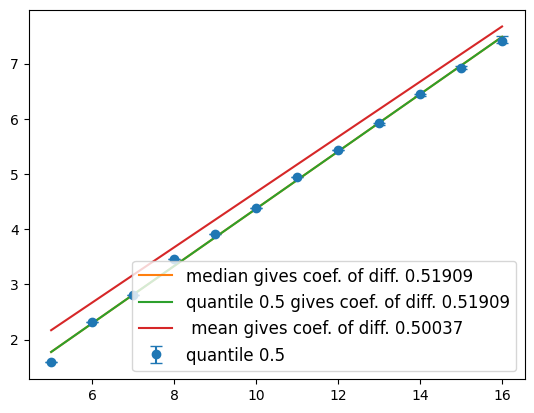

---------------------------Linear approximation-------------------------------------
------------------------------------------------------------------------------------
---------- quantile 0.5 gives |coeff. diff. - 0.5| = 0.019090407039692225 ----------


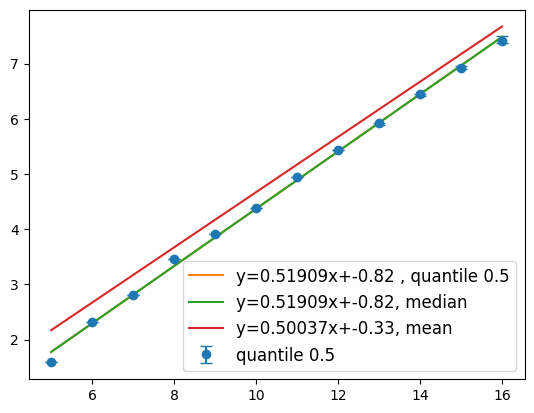

------------------------------------------------------------------------------------
---------------------------- Roberto's Estimator -----------------------------------
------------------------------------------------------------------------------------
-----------------------Non-linear approximation-------------------------------------
------------------------------------------------------------------------------------
----------- quantile 0.5 gives |coef. diff. - 0.5| = 0.0009561879147103047----------
------------------------------------------------------------------------------------
---------- f(k) = 0.415 + 0.501*k + 4.61e+14 * exp( -7.15*k) ---------------------


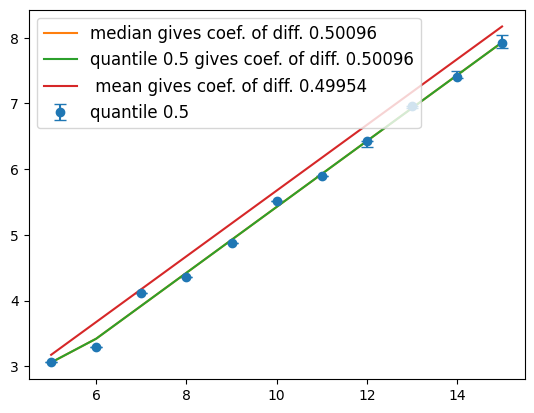

------------------------------------------------------------------------------------
---------------------------- Roberto's Estimator -----------------------------------
------------------------------------------------------------------------------------
---------------------------Linear approximation-------------------------------------
------------------------------------------------------------------------------------
---------- quantile 0.5 gives |coeff. diff. - 0.5| = 0.005354735485294804 ----------


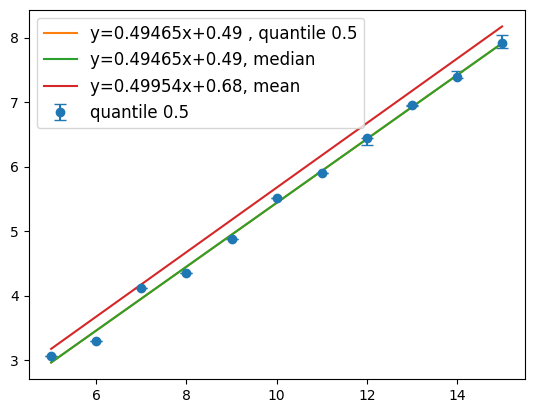

-----------------------Non-linear approximation-------------------------------------
------------------------------------------------------------------------------------
----------- quantile 0.75 gives |coef. diff. - 0.5| = 0.0009105100497798779----------
------------------------------------------------------------------------------------
---------- f(k) = 0.22 + 0.499*k + 3.64e+14 * exp( -7.18*k) ---------------------


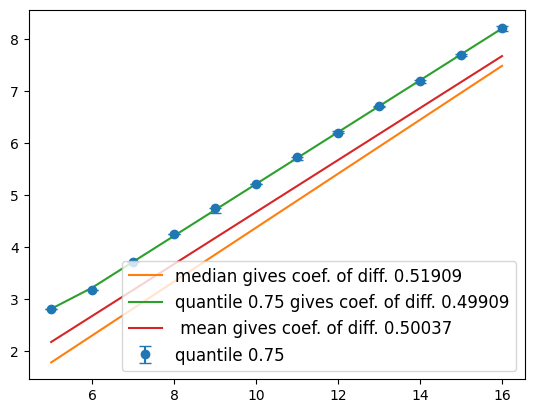

---------------------------Linear approximation-------------------------------------
------------------------------------------------------------------------------------
---------- quantile 0.75 gives |coeff. diff. - 0.5| = 0.004437298196908412 ----------


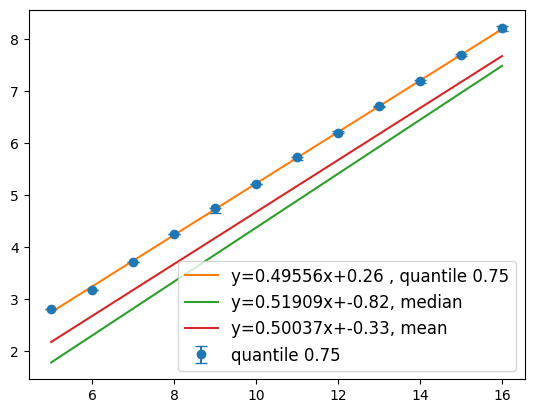

------------------------------------------------------------------------------------
---------------------------- Roberto's Estimator -----------------------------------
------------------------------------------------------------------------------------
-----------------------Non-linear approximation-------------------------------------
------------------------------------------------------------------------------------
----------- quantile 0.75 gives |coef. diff. - 0.5| = 0.0031966069249478313----------
------------------------------------------------------------------------------------
---------- f(k) = 1.17 + 0.503*k + -0.712 * exp( -6.66*k) ---------------------


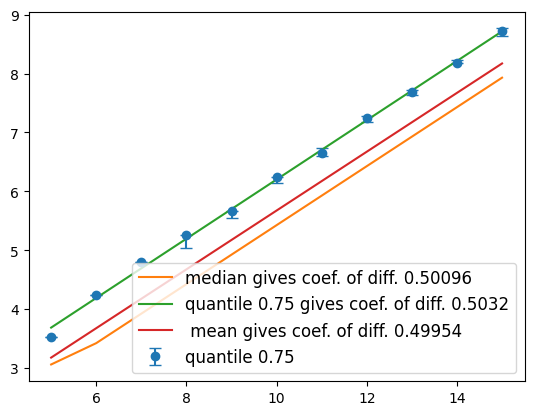

------------------------------------------------------------------------------------
---------------------------- Roberto's Estimator -----------------------------------
------------------------------------------------------------------------------------
---------------------------Linear approximation-------------------------------------
------------------------------------------------------------------------------------
---------- quantile 0.75 gives |coeff. diff. - 0.5| = 0.003196261701560954 ----------


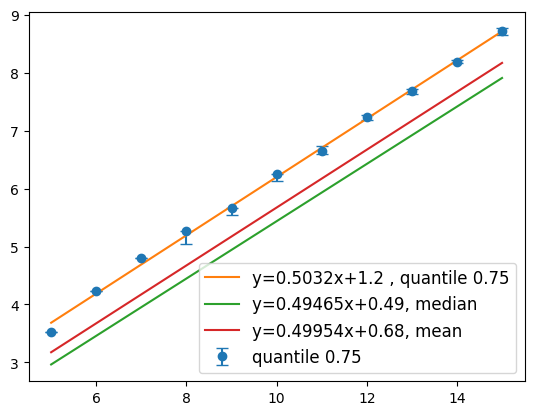

In [13]:

# regression 
regression(0.5 , Size, A, roberto = 'false')
regression(0.5 , Size, A, roberto = 'true')
regression(0.75, Size, A, roberto = 'false')
regression(0.75, Size, A, roberto = 'true')